# Problem Description
RMC, Inc. consists of three plants. Each of these plants sends it products to two warehouses, A and B. From these warehouses it then supplies four customers. Each plant has a given capacity to supply product. The cost to move product from a plant to a warehouse and from a warehouse to a customer varies by route. RMC, Inc. would like to determine the most cost effective way for supplying all four customers with its product. 

Adapted from:
Anderson, David R.; Sweeney, Dennis J.; Williams, Thomas A.; Camm, Jeffrey D.; Cochran, James J.. An Introduction to Management Science: Quantitative Approach (p. 270). Cengage Learning. Kindle Edition. 

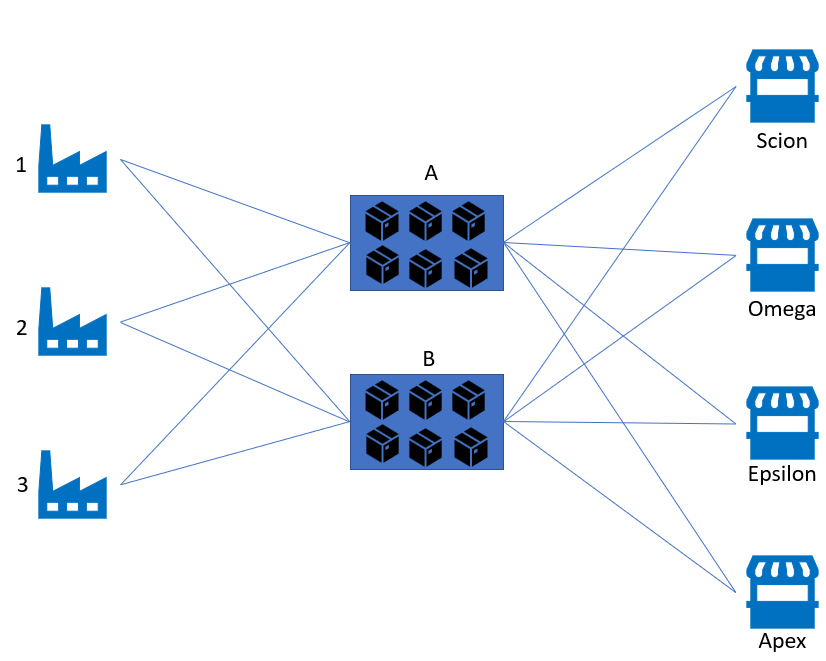

# Problem Definition
* Plants capacities for plants 1, 2, and 3 are 450 units/wk, 600 units/wk, and 380 units/wk, respectively.
* Shipping costs vary among the plant-warehouse and warehouse-customer routes. 
* Weekly demand varies among the fours customers Scion, Omega, Epsilon,  and Apex. 
* Only a single period is under consideration (i.e. 1 week).
* Inventory must remain balanced at each warehouse.


# Opportunity Statement
Determine the amount of product to ship from each plant and along which routes to ship that product so that shipping costs are minimized and all customer demand is met. 

# Model Development

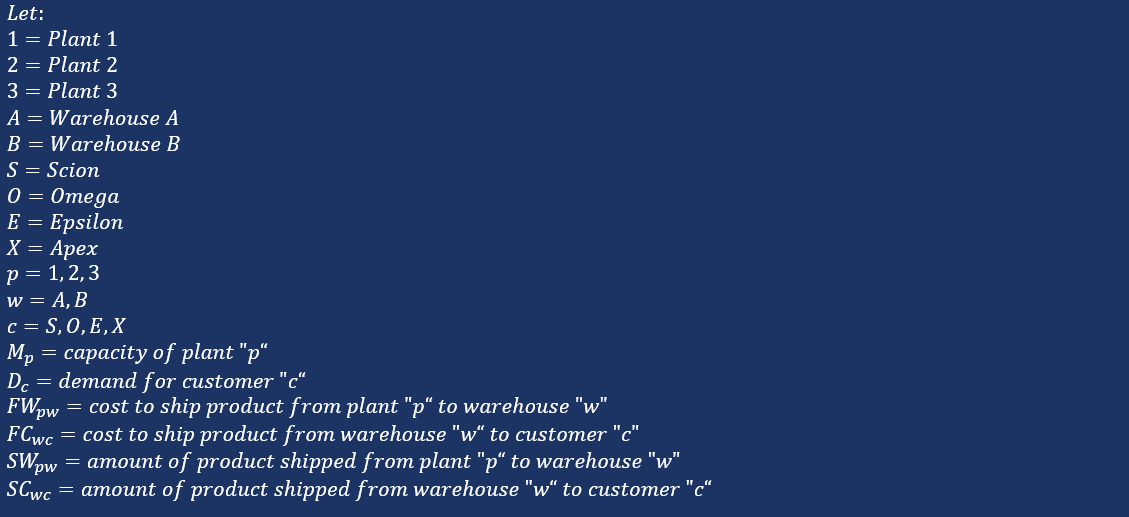

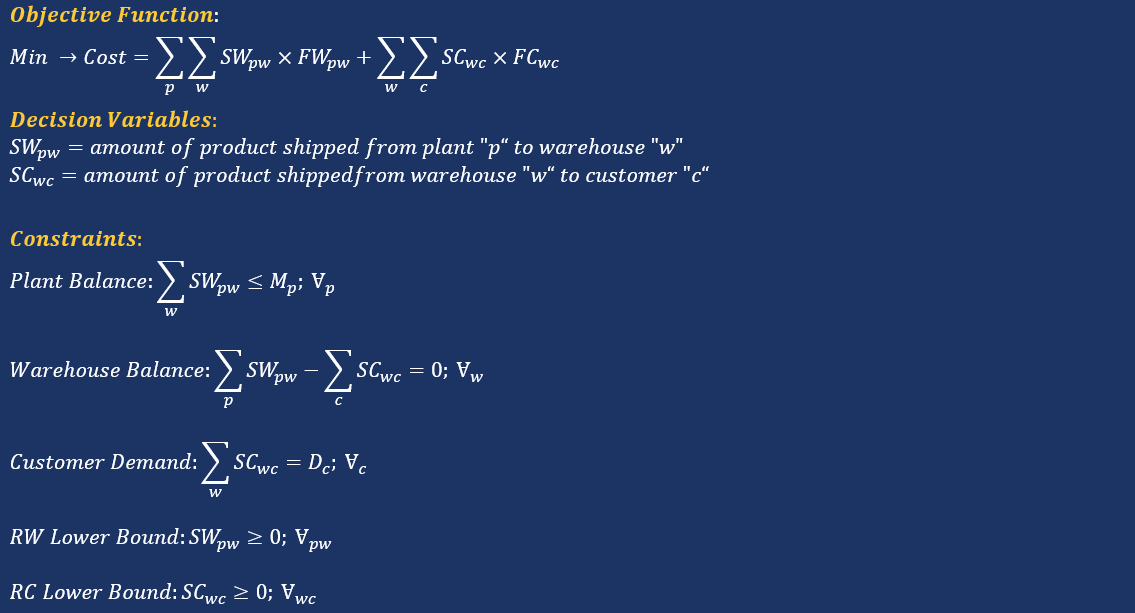

In [1]:
import pandas as pd
import numpy as np
import pulp

In [2]:
#read in data
dfPltShip = pd.read_excel("4_1_Data.xlsx","PlantShipping")
dfPlant = pd.read_excel("4_1_Data.xlsx","Plant")
dfCstShip= pd.read_excel("4_1_Data.xlsx","CustomerShipping")
dfDemand= pd.read_excel("4_1_Data.xlsx","Demand")

In [3]:
dfPltShip

,Plant,Warehouse,Shipping
0,1,A,4
1,1,B,7
2,2,A,8
3,2,B,5
4,3,A,5
5,3,B,6


In [4]:
dfPlant

,Plant,Capacity
0,1,450
1,2,600
2,3,380


In [5]:
dfCstShip

,Customer,Warehouse,Shipping
0,Scion,A,6
1,Scion,B,3
2,Omega,A,4
3,Omega,B,6
4,Epsilon,A,8
5,Epsilon,B,7
6,Apex,A,4
7,Apex,B,7


In [6]:
dfDemand

,Customer,Demand
0,Scion,300
1,Omega,300
2,Epsilon,300
3,Apex,400


In [24]:
#define input parameter values
plant=list(dfPlant['Plant'].unique())
warehouse=list(dfPltShip['Warehouse'].unique())
customer=list(dfDemand['Customer'].unique())


M={}
for i in dfPlant.index:
     M[dfPlant.loc[i,'Plant']]=dfPlant.loc[i,'Capacity']
        
D={}
for i in dfDemand.index:
     D[dfDemand.loc[i,'Customer']]=dfDemand.loc[i,'Demand']

FW={}
for p in plant:
    FW[p]=dict(zip(warehouse,[0]*len(warehouse)))
for i in dfPltShip.index:
    FW[dfPltShip.loc[i,'Plant']][dfPltShip.loc[i,'Warehouse']]=dfPltShip.loc[i,'Shipping']
    
FC={}
for w in warehouse:
    FC[w]=dict(zip(customer,[0]*len(customer)))
for i in dfCstShip.index:
    FC[dfCstShip.loc[i,'Warehouse']][dfCstShip.loc[i,'Customer']]=dfCstShip.loc[i,'Shipping']
    
    

In [8]:
M

{1: 450, 2: 600, 3: 380}

In [9]:
D

{'Scion': 300, 'Omega': 300, 'Epsilon': 300, 'Apex': 400}

In [10]:
FW

{1: {'A': 4, 'B': 7}, 2: {'A': 8, 'B': 5}, 3: {'A': 5, 'B': 6}}

In [11]:
FC

{'A': {'Scion': 6, 'Omega': 4, 'Epsilon': 8, 'Apex': 4},
 'B': {'Scion': 3, 'Omega': 6, 'Epsilon': 7, 'Apex': 7}}

## Build & Solve Model

In [12]:
#Step 1: Create Model Object
model = pulp.LpProblem("Transshipment", pulp.LpMinimize)

In [13]:
#Step 2: Create Decision Variables
plt_index=[]
for i in dfPltShip.index:
        plt_index.append((dfPltShip.loc[i,'Plant'],dfPltShip.loc[i,'Warehouse']))

cst_index=[]
for i in dfCstShip.index:
        cst_index.append((dfCstShip.loc[i,'Warehouse'],dfCstShip.loc[i,'Customer']))
        
SW = pulp.LpVariable.dicts('SW', ((p,w) for p,w in plt_index), lowBound=0, cat='Continuous')
SC = pulp.LpVariable.dicts('SC', ((w,c) for w,c in cst_index), lowBound=0, cat='Continuous')

In [14]:
SW

{(1, 'A'): SW_(1,_'A'),
 (1, 'B'): SW_(1,_'B'),
 (2, 'A'): SW_(2,_'A'),
 (2, 'B'): SW_(2,_'B'),
 (3, 'A'): SW_(3,_'A'),
 (3, 'B'): SW_(3,_'B')}

In [15]:
SC

{('A', 'Scion'): SC_('A',_'Scion'),
 ('B', 'Scion'): SC_('B',_'Scion'),
 ('A', 'Omega'): SC_('A',_'Omega'),
 ('B', 'Omega'): SC_('B',_'Omega'),
 ('A', 'Epsilon'): SC_('A',_'Epsilon'),
 ('B', 'Epsilon'): SC_('B',_'Epsilon'),
 ('A', 'Apex'): SC_('A',_'Apex'),
 ('B', 'Apex'): SC_('B',_'Apex')}

In [16]:
# Step 3: Add Objective Function
obj_fxn = 0
obj_fxn += pulp.lpSum([SW[p,w]*FW[p][w] for p,w in plt_index])
obj_fxn += pulp.lpSum([SC[w,c]*FC[w][c] for w,c in cst_index])
model += obj_fxn

In [17]:
#Step 4: Add Constraints

#plant balance
for p in plant:
        model += sum([SW[p,w] for w in warehouse]) <= M[p], 'Plant Balance'+'_'+str(p)

#warehouse balance
for w in warehouse:
    model += sum([SW[p,w] for p in plant])-sum([SC[w,c] for c in customer])==0, 'Warehouse Balance'+'_'+str(w)

#customer demand
for c in customer:
        model += sum([SC[w,c] for w in warehouse]) == D[c], 'Demand'+'_'+str(c)

#NOTE we did note at the non-negative constraints here because we already specificied them in the "lowBound" of the LpVariable class. 

In [25]:
#Step 5: Write the Model
model.writeLP("lp_model.lp")

[SC_('A',_'Apex'),
 SC_('A',_'Epsilon'),
 SC_('A',_'Omega'),
 SC_('A',_'Scion'),
 SC_('B',_'Apex'),
 SC_('B',_'Epsilon'),
 SC_('B',_'Omega'),
 SC_('B',_'Scion'),
 SW_(1,_'A'),
 SW_(1,_'B'),
 SW_(2,_'A'),
 SW_(2,_'B'),
 SW_(3,_'A'),
 SW_(3,_'B')]

In [19]:
#Step 6: Solve Model
model.solve(pulp.PULP_CBC_CMD(msg=True, keepFiles=False))
pulp.LpStatus[model.status]

'Optimal'

## Evaluation & Sensitivity Analysis

In [20]:
# look at objective value
model.objective.value()

11850.0

In [21]:
#create a data frame for storing decisions varialbles that will enable better reporting/aggregation
varClasses=[SW,SC]
varNames=['SW','SC']
varCase={'SW':'pw','SC':'wc'}

df_var=pd.DataFrame(columns=['plant','warehouse','customer','name','type'])

j=0

for i in varClasses:
    if varCase[varNames[j]]=='pw':
        ini_list=list(i.keys())
        df_dict={}
        
        tPlant=[k[0] for k in ini_list]
        tPlant={'plant':tPlant}
        df_dict.update(tPlant)
              
        tWrh=[k[1] for k in ini_list]
        tWrh={'warehouse': tWrh}
        df_dict.update(tWrh)
        
        tName=list(i.values())
        tName=[k.name for k in tName]
        tName={'name': tName}
        df_dict.update(tName)

        tType=varNames[j]
        tType={'type': tType}
        df_dict.update(tType)

        df_var=df_var.append(pd.DataFrame(df_dict))

    elif varCase[varNames[j]]=='wc':
        ini_list=list(i.keys())
        df_dict={}

        tWrh=[k[0] for k in ini_list]
        tWrh={'warehouse': tWrh}
        df_dict.update(tWrh)
              
        tCst=[k[1] for k in ini_list]
        tCst={'customer': tCst}
        df_dict.update(tCst)

        tName=list(i.values())
        tName=[i.name for i in tName]
        tName={'name': tName}
        df_dict.update(tName)

        tType=varNames[j]
        tType={'type': tType}
        df_dict.update(tType)

        df_var=df_var.append(pd.DataFrame(df_dict))    

    j+=1

df_var['name']=df_var['name'].astype(str)
df_var

,plant,warehouse,customer,name,type
0,1,A,NaN,"SW_(1,_'A')",SW
1,1,B,NaN,"SW_(1,_'B')",SW
2,2,A,NaN,"SW_(2,_'A')",SW
3,2,B,NaN,"SW_(2,_'B')",SW
4,3,A,NaN,"SW_(3,_'A')",SW
5,3,B,NaN,"SW_(3,_'B')",SW
0,NaN,A,Scion,"SC_('A',_'Scion')",SC
1,NaN,B,Scion,"SC_('B',_'Scion')",SC
2,NaN,A,Omega,"SC_('A',_'Omega')",SC
3,NaN,B,Omega,"SC_('B',_'Omega')",SC


In [22]:
#create data frame for df_var
df_var_rslt=pd.DataFrame()
lp_class=[]
var=[]
val=[]
rc=[]
for j in model.variables():
    lp_class.append('var')
    var.append(j)
    val.append(j.varValue)
    rc.append(j.dj)

df_var_rslt['class']=lp_class
df_var_rslt['name']=var
df_var_rslt['name']=df_var_rslt['name'].astype(str)
df_var_rslt['val']=np.round(val,2)
df_var_rslt['rc']=np.round(rc,2)
df_var_rslt['rc']=df_var_rslt['rc'].round(2)

df_var_rslt=df_var.merge(df_var_rslt, how='inner',left_on='name', right_on='name')
# df_var_rslt.to_excel("variables.xlsx",sheet_name='variables', index=False)
df_var_rslt

,plant,warehouse,customer,name,type,class,val,rc
0,1,A,NaN,"SW_(1,_'A')",SW,var,450.0,0.0
1,1,B,NaN,"SW_(1,_'B')",SW,var,0.0,3.0
2,2,A,NaN,"SW_(2,_'A')",SW,var,0.0,3.0
3,2,B,NaN,"SW_(2,_'B')",SW,var,600.0,0.0
4,3,A,NaN,"SW_(3,_'A')",SW,var,250.0,0.0
5,3,B,NaN,"SW_(3,_'B')",SW,var,0.0,1.0
6,NaN,A,Scion,"SC_('A',_'Scion')",SC,var,0.0,3.0
7,NaN,B,Scion,"SC_('B',_'Scion')",SC,var,300.0,0.0
8,NaN,A,Omega,"SC_('A',_'Omega')",SC,var,300.0,0.0
9,NaN,B,Omega,"SC_('B',_'Omega')",SC,var,0.0,2.0


In [23]:
#create data frame for df_const
df_const=pd.DataFrame()
lp_class=[]
const=[]
val=[]
slack=[]
dv=[]
for j in model.constraints.items():
    lp_class.append('constraint')
    const.append(j[0])
    val.append(sum([var.varValue * coefficient for var, coefficient in j[1].items()]))
    slack.append(j[1].slack)
    dv.append(j[1].pi)

df_const['class']=lp_class
df_const['name']=const
df_const['val']=np.round(val,2)
df_const['slack']=np.round(slack,2)
df_const['dv']=np.round(dv,2)

# df_const.to_excel("constraints.xlsx", sheet_name='constraints', index=False)
df_const

,class,name,val,slack,dv
0,constraint,Plant_Balance_1,450.0,-0.0,-1.0
1,constraint,Plant_Balance_2,600.0,-0.0,0.0
2,constraint,Plant_Balance_3,250.0,130.0,0.0
3,constraint,Warehouse_Balance_A,0.0,-0.0,5.0
4,constraint,Warehouse_Balance_B,0.0,-0.0,5.0
5,constraint,Demand_Scion,300.0,-0.0,8.0
6,constraint,Demand_Omega,300.0,-0.0,9.0
7,constraint,Demand_Epsilon,300.0,-0.0,12.0
8,constraint,Demand_Apex,400.0,-0.0,9.0
